In [15]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# **<u>Results of Static Premier League Scheduling</u>**


Since the goal is to improve the suspense of the premier league, we first have to look at how a static schedule performs.  
This will give us a baseline to compare with and based on these results we can try to see where improvements are possible.  

Besides looking for better schedules by rescheduling, it is also interesting to **`examine how different intial schedules perform even when there is no rescheduling possible`**.



## 1. Load the data 

In [16]:
match_relevance_static = pd.read_csv('matchRelevanceStatic.txt')
match_relevance_dynamic = pd.read_csv('matchRelevanceDynamic.txt')
match_relevance_dynamic_maximize_points_difference = pd.read_csv('matchRelevanceDynamicMaximizePointsDifferenceLaterRounds.txt')
df = pd.read_csv('rfModel.txt', sep=';')

In [17]:
df.tail()

,homeTeam,awayTeam,irrelevant
495,4,19,0
496,8,11,1
497,15,18,1
498,14,5,0
499,20,6,1


In [18]:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_auc_score
    import pandas as pd
    import numpy as np


    # We'll train only on rank_min and rank_max to treat (i,j) and (j,i) the same
    X = df[['homeTeam', 'awayTeam']]
    y = df['irrelevant']

    # Train/test split (optional)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest
    model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    # Evaluation
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.71      0.62      0.67        56
           1       0.59      0.68      0.63        44

    accuracy                           0.65       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.66      0.65      0.65       100

ROC AUC: 0.723823051948052


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np

def predict_match_irrelevance(df):
    
    # Use rank_min and rank_max to treat (i,j) and (j,i) symmetrically
    df['rank_min'] = df[['homeTeam', 'awayTeam']].min(axis=1)
    df['rank_max'] = df[['homeTeam', 'awayTeam']].max(axis=1)

    X = df[['rank_min', 'rank_max']]
    y = df['irrelevant']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    # Evaluation
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

    # Generate all unordered rank pairs (1-20)
    all_pairs = [(i, j) for i in range(1, 21) for j in range(1, 21) if i < j]
    pair_df = pd.DataFrame(all_pairs, columns=['rankA', 'rankB'])
    pair_df['rank_min'] = pair_df[['rankA', 'rankB']].min(axis=1)
    pair_df['rank_max'] = pair_df[['rankA', 'rankB']].max(axis=1)

    # Predict irrelevance probability
    pair_df['irrelevance_score'] = model.predict_proba(pair_df[['rank_min', 'rank_max']])[:, 1]

    return pair_df

# Example usage
# df should be your historical match data with 'homeTeam', 'awayTeam', and 'irrelevant'
# result_df = predict_match_irrelevance_


In [20]:
test = predict_match_irrelevance(df)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        56
           1       0.67      0.77      0.72        44

    accuracy                           0.73       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.74      0.73      0.73       100

ROC AUC: 0.729


In [21]:
test

,rankA,rankB,rank_min,rank_max,irrelevance_score
0,1,2,1,2,0.280525
1,1,3,1,3,0.280525
2,1,4,1,4,0.173344
3,1,5,1,5,0.594084
4,1,6,1,6,0.606210
...,...,...,...,...,...
185,17,19,17,19,0.350628
186,17,20,17,20,0.590768
187,18,19,18,19,0.277968
188,18,20,18,20,0.326981


## 2. Analyzing the suspense of static schedules

The suspsense/attractiveness will mainly be measured by looking at the final 5 rounds.  
For those rounds we will take a look at the number of (ir)relevant matches, but also at the number of teams that are still in the running for certain places (title, champions league, europa league, conference league and relegation).  


### 2.1 Random Static Schedules
Here we will analyze how random static schedules perform. We obtain the results by making 1000 random schedules and simulating different match outcomes.  
Typical round-robin constraints are included which makes sure that no team has more than two breaks over all the rounds. The schedule of the second half is simply the reverse of the first half. 

#### 2.1.1 Different types of matches during the last 5 rounds

A match is relevant for a team if the **title (top 1)**, **championsleague qualification (top 4)**, **europe league qualification (5-6)**, **conference league qualification (7)** or **relegation (bottom 3**) is dependent on it.   
- **Highly-Relevant matches** are matches that are relevant for both teams.  
- **Partially relevant** matches are matches that are only relevant for one of the teams.   
- **Irrelevant matches** are matches where both teams have nothing at stake.


When making a schedule, the goall will be to either maximize the number of highly-relevant matches or minimize the number of irrelevant matches.  
The assumption for now remains that there exists a tradeoff between the two 

##### 2.1.1.1 Irrelevant matches, relevant matches and partially relevant matches
Plot the amount of (ir)relevant matches and partially relevant matches we can expect

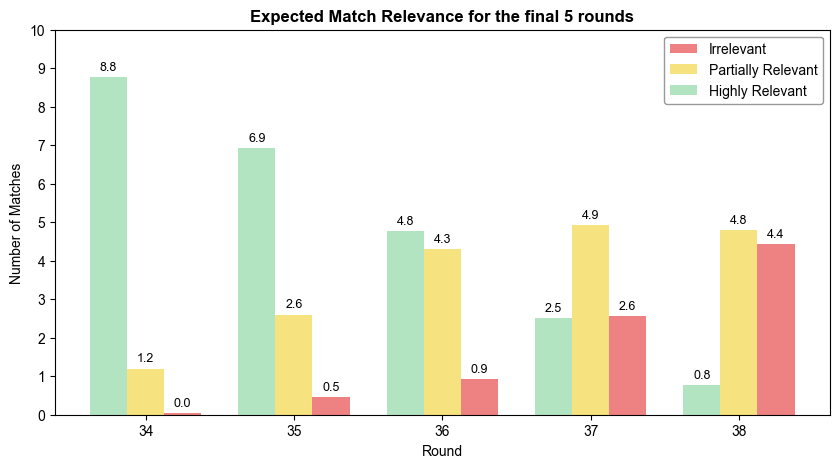

In [22]:
# Calculate the expected values for each type of match per round
expected_irrelevant = [
    match_relevance_static["irrelevant_matches_round_34"].mean(),
    match_relevance_static["irrelevant_matches_round_35"].mean(),
    match_relevance_static["irrelevant_matches_round_36"].mean(),
    match_relevance_static["irrelevant_matches_round_37"].mean(),
    match_relevance_static["irrelevant_matches_round_38"].mean()
]

expected_partially_relevant = [
    match_relevance_static["partially_relevant_matches_round_34"].mean(),
    match_relevance_static["partially_relevant_matches_round_35"].mean(),
    match_relevance_static["partially_relevant_matches_round_36"].mean(),
    match_relevance_static["partially_relevant_matches_round_37"].mean(),
    match_relevance_static["partially_relevant_matches_round_38"].mean()
]

expected_relevant = [
    match_relevance_static["highly_relevant_matches_round_34"].mean(),
    match_relevance_static["highly_relevant_matches_round_35"].mean(),
    match_relevance_static["highly_relevant_matches_round_36"].mean(),
    match_relevance_static["highly_relevant_matches_round_37"].mean(),
    match_relevance_static["highly_relevant_matches_round_38"].mean()
]

# Create the side-by-side bar plot
# Plot setup
rounds = np.arange(len(expected_irrelevant))
bar_width = 0.25
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars
p1 = ax.bar(rounds + bar_width, expected_irrelevant, bar_width, label='Irrelevant', color='#ee8283')
p2 = ax.bar(rounds, expected_partially_relevant, bar_width, label='Partially Relevant', color='#f6e27f')
p3 = ax.bar(rounds - bar_width, expected_relevant, bar_width, label='Highly Relevant', color='#b3e4c2')

# Add bar value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

add_labels(p1)
add_labels(p2)
add_labels(p3)

# Axis labels and styling
ax.set_xlabel('Round')
ax.set_ylabel('Number of Matches')
ax.set_title('Expected Match Relevance for the final 5 rounds', fontweight='bold')
ax.set_xticks(rounds)
ax.set_xticklabels([34, 35, 36, 37, 38])
plt.yticks(np.arange(0, 11, 1))

ax.legend(fontsize=10, loc='upper right', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)
plt.show()

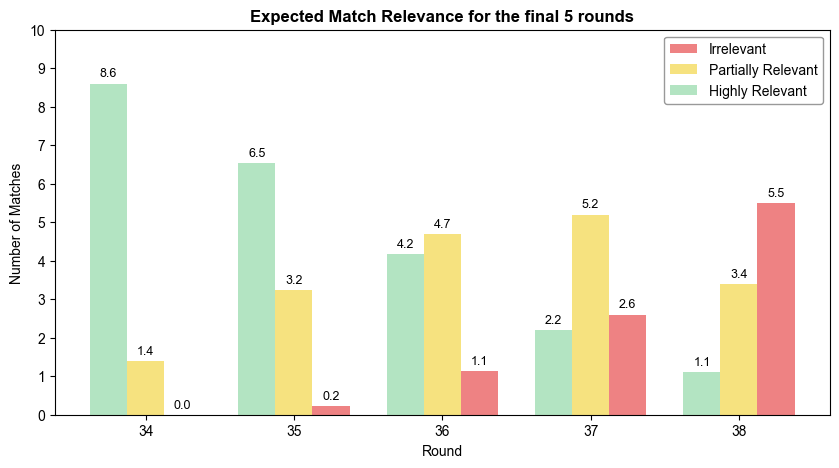

In [23]:
# Calculate the expected values for each type of match per round
expected_irrelevant = [
    match_relevance_dynamic["irrelevant_matches_round_34"].mean(),
    match_relevance_dynamic["irrelevant_matches_round_35"].mean(),
    match_relevance_dynamic["irrelevant_matches_round_36"].mean(),
    match_relevance_dynamic["irrelevant_matches_round_37"].mean(),
    match_relevance_dynamic["irrelevant_matches_round_38"].mean()
]

expected_partially_relevant = [
    match_relevance_dynamic["partially_relevant_matches_round_34"].mean(),
    match_relevance_dynamic["partially_relevant_matches_round_35"].mean(),
    match_relevance_dynamic["partially_relevant_matches_round_36"].mean(),
    match_relevance_dynamic["partially_relevant_matches_round_37"].mean(),
    match_relevance_dynamic["partially_relevant_matches_round_38"].mean()
]

expected_relevant = [
    match_relevance_dynamic["highly_relevant_matches_round_34"].mean(),
    match_relevance_dynamic["highly_relevant_matches_round_35"].mean(),
    match_relevance_dynamic["highly_relevant_matches_round_36"].mean(),
    match_relevance_dynamic["highly_relevant_matches_round_37"].mean(),
    match_relevance_dynamic["highly_relevant_matches_round_38"].mean()
]

# Create the side-by-side bar plot
# Plot setup
rounds = np.arange(len(expected_irrelevant))
bar_width = 0.25
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars
p1 = ax.bar(rounds + bar_width, expected_irrelevant, bar_width, label='Irrelevant', color='#ee8283')
p2 = ax.bar(rounds, expected_partially_relevant, bar_width, label='Partially Relevant', color='#f6e27f')
p3 = ax.bar(rounds - bar_width, expected_relevant, bar_width, label='Highly Relevant', color='#b3e4c2')

# Add bar value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

add_labels(p1)
add_labels(p2)
add_labels(p3)

# Axis labels and styling
ax.set_xlabel('Round')
ax.set_ylabel('Number of Matches')
ax.set_title('Expected Match Relevance for the final 5 rounds', fontweight='bold')
ax.set_xticks(rounds)
ax.set_xticklabels([34, 35, 36, 37, 38])
plt.yticks(np.arange(0, 11, 1))

ax.legend(fontsize=10, loc='upper right', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)
plt.show()

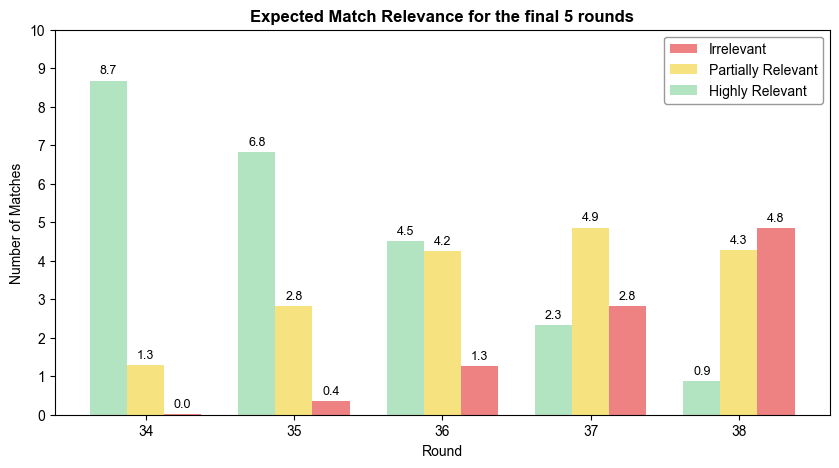

In [24]:
# Calculate the expected values for each type of match per round
expected_irrelevant = [
    match_relevance_dynamic_maximize_points_difference["irrelevant_matches_round_34"].mean(),
    match_relevance_dynamic_maximize_points_difference["irrelevant_matches_round_35"].mean(),
    match_relevance_dynamic_maximize_points_difference["irrelevant_matches_round_36"].mean(),
    match_relevance_dynamic_maximize_points_difference["irrelevant_matches_round_37"].mean(),
    match_relevance_dynamic_maximize_points_difference["irrelevant_matches_round_38"].mean()
]

expected_partially_relevant = [
    match_relevance_dynamic_maximize_points_difference["partially_relevant_matches_round_34"].mean(),
    match_relevance_dynamic_maximize_points_difference["partially_relevant_matches_round_35"].mean(),
    match_relevance_dynamic_maximize_points_difference["partially_relevant_matches_round_36"].mean(),
    match_relevance_dynamic_maximize_points_difference["partially_relevant_matches_round_37"].mean(),
    match_relevance_dynamic_maximize_points_difference["partially_relevant_matches_round_38"].mean()
]

expected_relevant = [
    match_relevance_dynamic_maximize_points_difference["highly_relevant_matches_round_34"].mean(),
    match_relevance_dynamic_maximize_points_difference["highly_relevant_matches_round_35"].mean(),
    match_relevance_dynamic_maximize_points_difference["highly_relevant_matches_round_36"].mean(),
    match_relevance_dynamic_maximize_points_difference["highly_relevant_matches_round_37"].mean(),
    match_relevance_dynamic_maximize_points_difference["highly_relevant_matches_round_38"].mean()
]

# Create the side-by-side bar plot
# Plot setup
rounds = np.arange(len(expected_irrelevant))
bar_width = 0.25
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars
p1 = ax.bar(rounds + bar_width, expected_irrelevant, bar_width, label='Irrelevant', color='#ee8283')
p2 = ax.bar(rounds, expected_partially_relevant, bar_width, label='Partially Relevant', color='#f6e27f')
p3 = ax.bar(rounds - bar_width, expected_relevant, bar_width, label='Highly Relevant', color='#b3e4c2')

# Add bar value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

add_labels(p1)
add_labels(p2)
add_labels(p3)

# Axis labels and styling
ax.set_xlabel('Round')
ax.set_ylabel('Number of Matches')
ax.set_title('Expected Match Relevance for the final 5 rounds', fontweight='bold')
ax.set_xticks(rounds)
ax.set_xticklabels([34, 35, 36, 37, 38])
plt.yticks(np.arange(0, 11, 1))

ax.legend(fontsize=10, loc='upper right', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)
plt.show()

##### 2.1.1.2 Teams in contention
Start by plotting the teams for whom the place is fixed


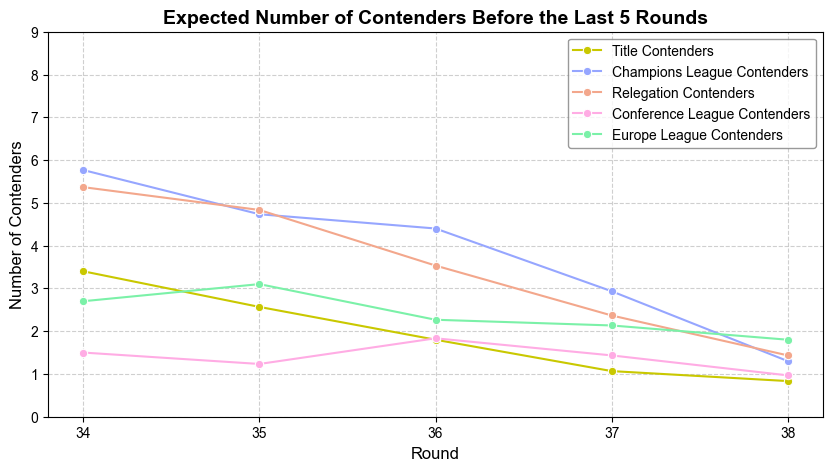

In [25]:
title_runners_mean = match_relevance_static[[col for col in match_relevance_static.columns if "title_contenders" in col]]
title_runners_mean = title_runners_mean.mean(axis = 0).reset_index()[0]

champions_league_runners_mean = match_relevance_static[[col for col in match_relevance_static.columns if "champions_league_contenders" in col]]
champions_league_runners_mean = champions_league_runners_mean.mean(axis = 0).reset_index()[0]

europe_league_contenders_mean =  match_relevance_static[[col for col in match_relevance_static.columns if "europe_league_contenders" in col]]
europe_league_contenders_mean = europe_league_contenders_mean.mean(axis = 0).reset_index()[0]

conference_league_contenders_mean = match_relevance_static[[col for col in match_relevance_static.columns if "conference_league_contenders" in col]]
conference_league_contenders_mean = conference_league_contenders_mean.mean(axis = 0).reset_index()[0]


relegation_runners_mean = match_relevance_static[[col for col in match_relevance_static.columns if "relegation_contenders" in col]]
relegation_runners_mean = relegation_runners_mean.mean(axis = 0).reset_index()[0]


no_contenders_mean = match_relevance_static[[col for col in match_relevance_static.columns if "no_contenders" in col]]
no_contenders_mean = no_contenders_mean.mean(axis = 0).reset_index()[0]


# Ensure Arial font is used
plt.rcParams['font.family'] = 'Arial'

# Define pastel color palette
pastel_colors = ["#c9c800", "#96a6ff", "#f3a78c", "#bfa2d7", "#fface4", "#7bf1a8"]
# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Round': [34, 35, 36, 37, 38],
    'Title Contenders': title_runners_mean,
    'Champions League Contenders': champions_league_runners_mean,
    'Relegation Contenders': relegation_runners_mean,
    'No Stakes': no_contenders_mean,
    'Europe League Contenders': europe_league_contenders_mean,
    'Conference League Contenders': conference_league_contenders_mean
})

# Create figure
plt.figure(figsize=(10, 5))

# Plot with pastel colors
sns.lineplot(data=plot_data, x='Round', y='Title Contenders', marker='o', label='Title Contenders', color=pastel_colors[0])
sns.lineplot(data=plot_data, x='Round', y='Champions League Contenders', marker='o', label='Champions League Contenders', color=pastel_colors[1])
sns.lineplot(data=plot_data, x='Round', y='Relegation Contenders', marker='o', label='Relegation Contenders', color=pastel_colors[2])
#sns.lineplot(data=plot_data, x='Round', y='No Stakes', marker='o', label='Teams with no stakes', color=pastel_colors[3])
sns.lineplot(data=plot_data, x='Round', y='Conference League Contenders', marker='o', label='Conference League Contenders', color=pastel_colors[4])
sns.lineplot(data=plot_data, x='Round', y='Europe League Contenders', marker='o', label='Europe League Contenders', color=pastel_colors[5])



# Add labels and title
plt.xlabel('Round', fontsize=12)
plt.ylabel('Number of Contenders', fontsize=12)
plt.title('Expected Number of Contenders Before the Last 5 Rounds', fontsize=14, fontweight='bold')

# Adjust legend
plt.legend(fontsize=10, loc='upper right', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

# Set x-ticks and y-ticks
plt.xticks(ticks=[34, 35, 36, 37, 38], fontsize=10)
plt.yticks(ticks=range(0, 10), fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()


In [26]:
# Ensure Arial font is used
plt.rcParams['font.family'] = 'Arial'

# Define pastel color palette
pastel_colors = ["#c9c800", "#96a6ff", "#f3a78c", "#bfa2d7", "#fface4", "#7bf1a8"]

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Count': [title_runners_mean_38, champions_league_runners_mean_38, relegation_runners_mean_38, europe_league_contenders_mean_38, conference_league_contenders_mean_38], 
    'Category': ['Title Contenders', 'Champions League Contenders', 'Relegation Contenders', 'Europe League Contenders', 'Conference League Contenders'],
})

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot with pastel colors
bars = sns.barplot(data=plot_data, x='Count', y='Category', palette=pastel_colors, ax=ax)

# Add value labels to the bars
for bar in bars.containers:
    bars.bar_label(bar, fmt='%.2f', label_type='edge', fontsize=10)

# Show the plot
plt.show()

NameError: name 'title_runners_mean_38' is not defined

In [ ]:
# Create figure
plt.figure(figsize=(10, 5))

sns.lineplot(data=plot_data, x='Round', y='No Stakes', marker='o', label='Teams with no stakes', color=pastel_colors[5])

plt.xlabel('Round', fontsize=12)
plt.ylabel('Number of Teams', fontsize=12)

plt.title('Expected Number of Teams with No Stakes Before the Last 5 Rounds', fontsize=14, fontweight='bold')

plt.legend(fontsize=10, loc='upper left', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

plt.xticks(ticks=[34, 35, 36, 37, 38], fontsize=10)
plt.yticks(ticks=range(0, 20), fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)



ValueError: Could not interpret value `Round` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

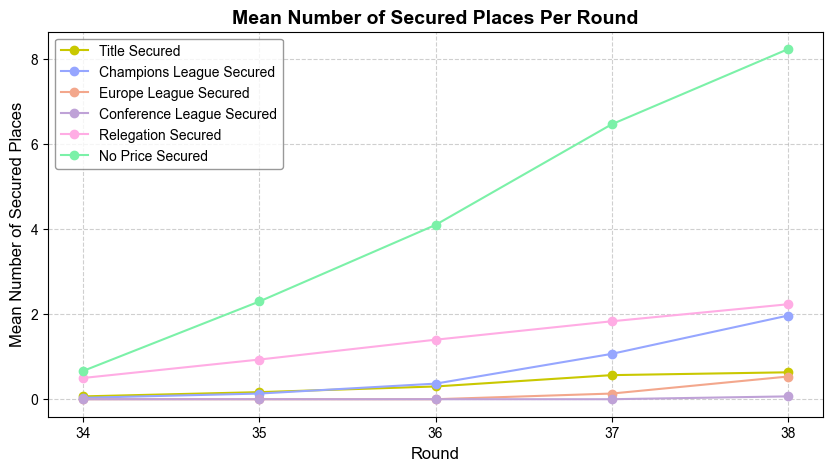

In [ ]:
# plot the number of teams that have secured places per category (title, champions league, europe league, conference league, relegation) in the last 5 rounds
match_relevance_static.head()

confirmed_places = match_relevance_static[[col for col in match_relevance_static.columns if "secured" in col]]
confirmed_places.columns

title_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "title" in col]].mean(axis = 0))
champions_league_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "champions_league" in col]].mean(axis = 0))
relegation_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "relegation" in col]].mean(axis = 0))
europe_league_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "europe_league" in col]].mean(axis = 0))
conference_league_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "conference_league" in col]].mean(axis = 0))
no_price_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "no_price" in col]].mean(axis = 0))


rounds = np.arange(34, 39)

# Plot the mean number of secured places per round for all the different categories as a line chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each category
ax.plot(rounds, title_secured_mean.values(), marker='o', label='Title Secured', color=pastel_colors[0])
ax.plot(rounds, champions_league_secured_mean.values(), marker='o', label='Champions League Secured', color=pastel_colors[1])
ax.plot(rounds, europe_league_secured_mean.values(), marker='o', label='Europe League Secured', color=pastel_colors[2])
ax.plot(rounds, conference_league_secured_mean.values(), marker='o', label='Conference League Secured', color=pastel_colors[3])
ax.plot(rounds, relegation_secured_mean.values(), marker='o', label='Relegation Secured', color=pastel_colors[4])
ax.plot(rounds, no_price_secured_mean.values(), marker='o', label='No Price Secured', color=pastel_colors[5])

# Add labels, title, and legend
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Mean Number of Secured Places', fontsize=12)
ax.set_title('Mean Number of Secured Places Per Round', fontsize=14, fontweight='bold')
ax.set_xticks(rounds)
ax.legend(fontsize=10, loc='upper left', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()